In [13]:
#!pip install torchmetrics

In [14]:
import copy
import random
import cv2
import functools
import torch
import torchmetrics
import pandas as pd
import seaborn as sns
import torchvision.transforms as transforms
import numpy as np

from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from torch.optim import Adam
from glob import glob
from torch import nn
from torchvision.transforms import functional
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset
from torchvision import io

In [15]:
def set_random_seeds():
    torch.manual_seed(52)
    random.seed(52)

# **Подготовка датасета**

In [16]:
#!gdown 11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe

In [17]:
#!unzip /content/dataset.zip

In [18]:
class ImagesDataset(Dataset):
    def __init__(self, images, masks, transform=lambda x: x):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def _crop_image(self, img):
        return transforms.functional.crop(img, 0, 0, 768, 512)

    def __getitem__(self, idx):
        img = self.transform(self._crop_image(io.read_image(str(self.images[idx]))) / 255)
        mask = self.transform(self._crop_image(io.read_image(str(self.masks[idx]))) / 255)
        return img, mask


In [19]:
def display_image(image, mask):
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(functional.to_pil_image(image))
    ax[1].imshow(functional.to_pil_image(mask))

In [20]:
images_path = sorted(Path("dataset/images").iterdir())
masks_path = sorted(Path("dataset/masks").iterdir())

Разделим датасет на тренировочную и тестовую выборки в соотношении 9:1.

In [21]:
train_part = 0.9
train_len = int(len(images_path) * train_part)

test_dataset = ImagesDataset(images=images_path[train_len:], masks=masks_path[train_len:])
train_dataset = ImagesDataset(images=images_path[:train_len], masks=masks_path[:train_len])

Train size: 1800
Test size: 200
torch.Size([3, 768, 512])
torch.Size([1, 768, 512])


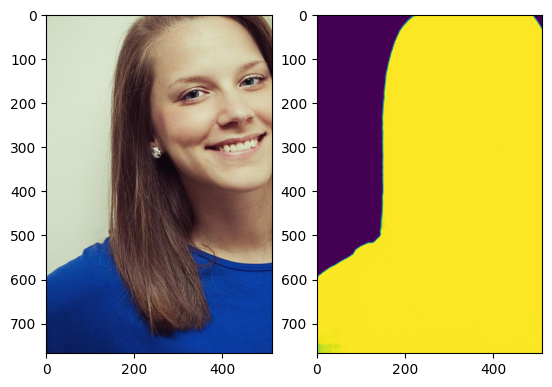

In [22]:
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

image, mask = train_dataset[52]
display_image(image, mask)

print(image.shape)
print(mask.shape)

# **U-net**

In [23]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x


class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

# **Функции для экспериментов**

In [24]:
criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.JaccardIndex(task="binary")

In [25]:
def test(model, loader):
  model.eval()

  running_loss = 0.0
  jaccard_metr = 0.0
  with torch.no_grad():
      for x, y in tqdm(loader):
          outputs = model(x.cuda())
          loss = criterion(outputs, y.cuda())
          running_loss += loss.item()
          jaccard_metr += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

  return running_loss / len(loader), jaccard_metr / len(loader)

In [26]:
def train(epochs, model, train_loader, test_loader, optimizer):
  train_stats = []
  test_stats = []

  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    jaccard_metr = 0.0
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(x.cuda())

        loss = criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        jaccard_metr += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

    train_loss = running_loss / len(train_loader)
    train_jaccard = jaccard_metr / len(train_loader)
    train_stat = (train_loss, train_jaccard)

    test_loss, test_jaccard = test(model, test_loader)
    test_stat = (test_loss, test_jaccard)

    train_stats.append(train_stat)
    test_stats.append(test_stat)
    print(epoch + 1, " Train loss: ", train_loss, ", train jaccard: ", train_jaccard, ", test loss: ", test_loss, ", test jaccard: ", test_jaccard)

  return train_stats, test_stats

# **Функции для визуализации**

In [27]:
def display_stats(train_stats, test_stats, title):
    loss_results, jaccard_results = [], []
    i = 1
    for i, (loss, jaccard) in enumerate(train_stats):
        loss_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": loss,
            }
        )
        jaccard_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": jaccard,
            }
        )
    for i, (loss, jaccard) in enumerate(test_stats):
        loss_results.append(
            {
                "Epoch": i,
                "Type": "Test",
                "Value": loss,
            }
        )
        jaccard_results.append(
            {
                "Epoch": i,
                "Type": "Test",
                "Value": jaccard,
            }
        )

    lossDf = pd.DataFrame(loss_results)
    jaccardDf = pd.DataFrame(jaccard_results)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(15, 7))
    sns.lineplot(lossDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[0])
    axs[0].set_title("Loss")

    sns.lineplot(jaccardDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[1])
    axs[1].set_title("Jaccard index")

    fig.suptitle(title)
    fig.tight_layout()

In [28]:
def worst_cases(model, n, idx):
    if len(idx) == 0:
        results = []
        with torch.no_grad():
            for i, (x, y) in enumerate(test_dataset):
                outputs = model(x.cuda().unsqueeze(0))[0]
                jaccard_metr = (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()
                results.append((jaccard_metr, i))
        idx = [i for _, i in sorted(results)[:n]]
    with torch.no_grad():
        for i in idx:
            x, y = test_dataset[i]
            outputs = model(x.cuda().unsqueeze(0))[0]
            display_image(x, nn.functional.sigmoid(outputs.cpu()))

    return idx

# **Переобучение на одном батче**

В качестве батча возьмем 4 картинки. Количество эпох обучения &mdash; 80.

In [29]:
set_random_seeds()

In [30]:
batch_size = 4

train_loader = DataLoader(
    Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = DataLoader(
    Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

In [31]:
model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats, test_stats = train(
    80, model, train_loader, test_loader, optimizer
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1  Train loss:  0.6934336423873901 , train jaccard:  0.46208813786506653 , test loss:  0.6927618980407715 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2  Train loss:  0.6295211315155029 , train jaccard:  0.6558372974395752 , test loss:  0.6926347613334656 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3  Train loss:  0.5876168608665466 , train jaccard:  0.7640122175216675 , test loss:  0.6923785209655762 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4  Train loss:  0.5638211965560913 , train jaccard:  0.7887489795684814 , test loss:  0.6920744180679321 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5  Train loss:  0.5440025329589844 , train jaccard:  0.7988948822021484 , test loss:  0.6917416453361511 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6  Train loss:  0.527025580406189 , train jaccard:  0.8061357140541077 , test loss:  0.6914682388305664 , test jaccard:  0.03723211959004402


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

7  Train loss:  0.5111434459686279 , train jaccard:  0.8192934393882751 , test loss:  0.6912734508514404 , test jaccard:  0.49979615211486816


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

8  Train loss:  0.497553288936615 , train jaccard:  0.8362830281257629 , test loss:  0.6910969614982605 , test jaccard:  0.5273891091346741


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9  Train loss:  0.4866456389427185 , train jaccard:  0.8489192128181458 , test loss:  0.6908499002456665 , test jaccard:  0.49799150228500366


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

10  Train loss:  0.4764705300331116 , train jaccard:  0.8639081120491028 , test loss:  0.6906068325042725 , test jaccard:  0.4865218997001648


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

11  Train loss:  0.4658283591270447 , train jaccard:  0.8866053819656372 , test loss:  0.6901867389678955 , test jaccard:  0.4858042895793915


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12  Train loss:  0.45798763632774353 , train jaccard:  0.922124445438385 , test loss:  0.6911823153495789 , test jaccard:  0.48405012488365173


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

13  Train loss:  0.4528614282608032 , train jaccard:  0.892939031124115 , test loss:  0.6887525320053101 , test jaccard:  0.5022916197776794


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

14  Train loss:  0.4488280713558197 , train jaccard:  0.9235309958457947 , test loss:  0.6860005259513855 , test jaccard:  0.5395453572273254


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15  Train loss:  0.4389892816543579 , train jaccard:  0.9186494946479797 , test loss:  0.6697806119918823 , test jaccard:  0.5119876861572266


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

16  Train loss:  0.4317002296447754 , train jaccard:  0.9523752927780151 , test loss:  0.6618496179580688 , test jaccard:  0.4776163399219513


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

17  Train loss:  0.42555660009384155 , train jaccard:  0.9591827988624573 , test loss:  0.6717574000358582 , test jaccard:  0.3651418089866638


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

18  Train loss:  0.419766366481781 , train jaccard:  0.9585469961166382 , test loss:  0.6382755041122437 , test jaccard:  0.5292842388153076


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

19  Train loss:  0.41307103633880615 , train jaccard:  0.9674738049507141 , test loss:  0.6412220001220703 , test jaccard:  0.5269379615783691


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

20  Train loss:  0.40984341502189636 , train jaccard:  0.9498685598373413 , test loss:  0.6486114263534546 , test jaccard:  0.5199160575866699


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

21  Train loss:  0.4032711982727051 , train jaccard:  0.9737884402275085 , test loss:  0.6522929668426514 , test jaccard:  0.5247213840484619


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

22  Train loss:  0.3997219502925873 , train jaccard:  0.9719921350479126 , test loss:  0.6632376313209534 , test jaccard:  0.520022988319397


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

23  Train loss:  0.395155668258667 , train jaccard:  0.9725853204727173 , test loss:  0.6778038740158081 , test jaccard:  0.5160619020462036


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

24  Train loss:  0.3898102045059204 , train jaccard:  0.9786325693130493 , test loss:  0.6938270330429077 , test jaccard:  0.5172936916351318


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

25  Train loss:  0.3860330581665039 , train jaccard:  0.9779664278030396 , test loss:  0.7065448760986328 , test jaccard:  0.5126340389251709


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

26  Train loss:  0.3824061155319214 , train jaccard:  0.9791020154953003 , test loss:  0.7213939428329468 , test jaccard:  0.5006645917892456


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

27  Train loss:  0.37954461574554443 , train jaccard:  0.9731076955795288 , test loss:  0.716707706451416 , test jaccard:  0.49545660614967346


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

28  Train loss:  0.37425166368484497 , train jaccard:  0.9816044569015503 , test loss:  0.7206350564956665 , test jaccard:  0.4891808331012726


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

29  Train loss:  0.37135109305381775 , train jaccard:  0.9800127744674683 , test loss:  0.716383159160614 , test jaccard:  0.4969886839389801


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

30  Train loss:  0.36844682693481445 , train jaccard:  0.9801640510559082 , test loss:  0.7465216517448425 , test jaccard:  0.4700474441051483


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

31  Train loss:  0.36471912264823914 , train jaccard:  0.9769693613052368 , test loss:  0.7459795475006104 , test jaccard:  0.46449145674705505


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

32  Train loss:  0.36515387892723083 , train jaccard:  0.970498263835907 , test loss:  0.719875693321228 , test jaccard:  0.468238890171051


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

33  Train loss:  0.3589598834514618 , train jaccard:  0.9753013253211975 , test loss:  0.7088362574577332 , test jaccard:  0.46300509572029114


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

34  Train loss:  0.35127660632133484 , train jaccard:  0.9831113815307617 , test loss:  0.7044872045516968 , test jaccard:  0.4546509385108948


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

35  Train loss:  0.35079360008239746 , train jaccard:  0.9780387282371521 , test loss:  0.7345280647277832 , test jaccard:  0.40796956419944763


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

36  Train loss:  0.34821200370788574 , train jaccard:  0.9746483564376831 , test loss:  0.7251366376876831 , test jaccard:  0.42464521527290344


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

37  Train loss:  0.3415897488594055 , train jaccard:  0.9847778677940369 , test loss:  0.72930908203125 , test jaccard:  0.4238945245742798


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

38  Train loss:  0.33969753980636597 , train jaccard:  0.9831257462501526 , test loss:  0.7151203155517578 , test jaccard:  0.4294835031032562


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

39  Train loss:  0.3357069492340088 , train jaccard:  0.9835934638977051 , test loss:  0.754729151725769 , test jaccard:  0.4056670367717743


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

40  Train loss:  0.33238357305526733 , train jaccard:  0.9811697006225586 , test loss:  0.753717303276062 , test jaccard:  0.4222739338874817


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

41  Train loss:  0.3291992247104645 , train jaccard:  0.9797478914260864 , test loss:  0.7311179041862488 , test jaccard:  0.43227332830429077


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

42  Train loss:  0.32454290986061096 , train jaccard:  0.9863343834877014 , test loss:  0.7176699042320251 , test jaccard:  0.44124045968055725


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

43  Train loss:  0.3225722312927246 , train jaccard:  0.9847627878189087 , test loss:  0.7169311046600342 , test jaccard:  0.45023858547210693


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

44  Train loss:  0.31870150566101074 , train jaccard:  0.9860115647315979 , test loss:  0.7250543832778931 , test jaccard:  0.45937439799308777


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

45  Train loss:  0.3144358992576599 , train jaccard:  0.9880778193473816 , test loss:  0.7367672324180603 , test jaccard:  0.4647130072116852


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

46  Train loss:  0.31182417273521423 , train jaccard:  0.9865909218788147 , test loss:  0.739223837852478 , test jaccard:  0.46531739830970764


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

47  Train loss:  0.3086690604686737 , train jaccard:  0.9868791699409485 , test loss:  0.7353348731994629 , test jaccard:  0.4638814628124237


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

48  Train loss:  0.30517908930778503 , train jaccard:  0.9888284206390381 , test loss:  0.7336136698722839 , test jaccard:  0.4706866145133972


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

49  Train loss:  0.302196741104126 , train jaccard:  0.9897975325584412 , test loss:  0.7407717704772949 , test jaccard:  0.4857781231403351


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

50  Train loss:  0.2989628314971924 , train jaccard:  0.9906803369522095 , test loss:  0.7629914283752441 , test jaccard:  0.504597544670105


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

51  Train loss:  0.2958882749080658 , train jaccard:  0.9900562763214111 , test loss:  0.7932236194610596 , test jaccard:  0.5145819783210754


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

52  Train loss:  0.2930237054824829 , train jaccard:  0.98935866355896 , test loss:  0.7990130186080933 , test jaccard:  0.5189689993858337


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

53  Train loss:  0.2899429202079773 , train jaccard:  0.9899169206619263 , test loss:  0.7812854647636414 , test jaccard:  0.5197009444236755


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

54  Train loss:  0.2871260643005371 , train jaccard:  0.990411639213562 , test loss:  0.7655096054077148 , test jaccard:  0.516852855682373


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

55  Train loss:  0.28425899147987366 , train jaccard:  0.9910102486610413 , test loss:  0.7556650042533875 , test jaccard:  0.5130185484886169


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

56  Train loss:  0.2813279628753662 , train jaccard:  0.9915375709533691 , test loss:  0.7451815605163574 , test jaccard:  0.5096653699874878


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

57  Train loss:  0.2786402106285095 , train jaccard:  0.9913987517356873 , test loss:  0.7324942946434021 , test jaccard:  0.5096282362937927


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

58  Train loss:  0.2757701873779297 , train jaccard:  0.9918698668479919 , test loss:  0.7226032018661499 , test jaccard:  0.5119561553001404


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

59  Train loss:  0.2730623185634613 , train jaccard:  0.9919368624687195 , test loss:  0.7198306322097778 , test jaccard:  0.5145615935325623


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

60  Train loss:  0.27037283778190613 , train jaccard:  0.9920231103897095 , test loss:  0.7231040000915527 , test jaccard:  0.5152187943458557


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

61  Train loss:  0.26762500405311584 , train jaccard:  0.9924556612968445 , test loss:  0.7204136848449707 , test jaccard:  0.5123850107192993


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

62  Train loss:  0.2650150656700134 , train jaccard:  0.9926429390907288 , test loss:  0.7087453603744507 , test jaccard:  0.5080018639564514


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

63  Train loss:  0.2622784972190857 , train jaccard:  0.9931173920631409 , test loss:  0.700351357460022 , test jaccard:  0.5062767863273621


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

64  Train loss:  0.2597513794898987 , train jaccard:  0.993147075176239 , test loss:  0.6982113122940063 , test jaccard:  0.5095966458320618


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

65  Train loss:  0.25718969106674194 , train jaccard:  0.9930281043052673 , test loss:  0.6992145776748657 , test jaccard:  0.5150647759437561


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

66  Train loss:  0.25466081500053406 , train jaccard:  0.9931705594062805 , test loss:  0.694083571434021 , test jaccard:  0.5211538076400757


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

67  Train loss:  0.25214946269989014 , train jaccard:  0.9936695694923401 , test loss:  0.6796205043792725 , test jaccard:  0.5291309952735901


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

68  Train loss:  0.24969267845153809 , train jaccard:  0.9940187931060791 , test loss:  0.6641666293144226 , test jaccard:  0.5374158620834351


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

69  Train loss:  0.2471822202205658 , train jaccard:  0.994185745716095 , test loss:  0.6509509086608887 , test jaccard:  0.5431363582611084


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

70  Train loss:  0.2447780817747116 , train jaccard:  0.9939370155334473 , test loss:  0.6392385959625244 , test jaccard:  0.5480960607528687


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

71  Train loss:  0.24237710237503052 , train jaccard:  0.9940358996391296 , test loss:  0.6323443651199341 , test jaccard:  0.5518581867218018


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

72  Train loss:  0.24003790318965912 , train jaccard:  0.9943576455116272 , test loss:  0.6305244565010071 , test jaccard:  0.5576143860816956


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

73  Train loss:  0.2376478910446167 , train jaccard:  0.9947335124015808 , test loss:  0.6304099559783936 , test jaccard:  0.5617512464523315


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

74  Train loss:  0.23536638915538788 , train jaccard:  0.9947529435157776 , test loss:  0.626294732093811 , test jaccard:  0.5618899464607239


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

75  Train loss:  0.2330719232559204 , train jaccard:  0.9948573112487793 , test loss:  0.6245339512825012 , test jaccard:  0.5588442087173462


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

76  Train loss:  0.2308124601840973 , train jaccard:  0.9948605298995972 , test loss:  0.6247490644454956 , test jaccard:  0.5569915175437927


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

77  Train loss:  0.22859959304332733 , train jaccard:  0.9948601722717285 , test loss:  0.6240589022636414 , test jaccard:  0.5574150681495667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

78  Train loss:  0.2263515293598175 , train jaccard:  0.9952982664108276 , test loss:  0.6243752241134644 , test jaccard:  0.5602095127105713


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

79  Train loss:  0.2241729497909546 , train jaccard:  0.9953333139419556 , test loss:  0.6252516508102417 , test jaccard:  0.5603348612785339


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

80  Train loss:  0.222027987241745 , train jaccard:  0.9952406287193298 , test loss:  0.6248502731323242 , test jaccard:  0.5561903715133667


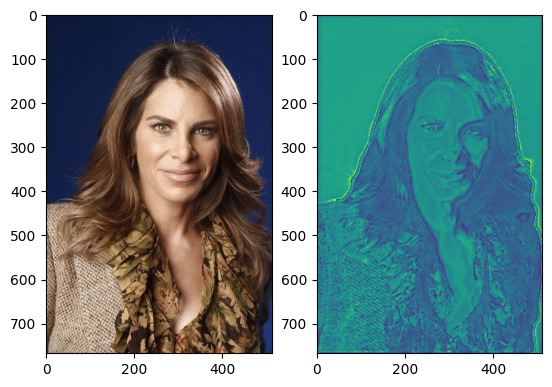

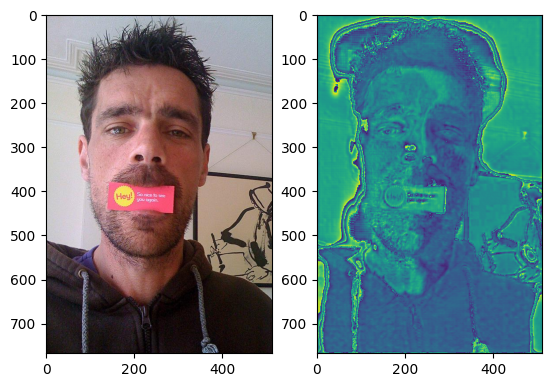

In [32]:
model.eval()

X, _ = train_dataset[0]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
display_image(X, pred)

X, _ = test_dataset[0]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
display_image(X, pred)

Как можно видеть, на тестовой картинке модель не видит силуэта человека, хотя на картинке из батча образ человека виден отчетливо.

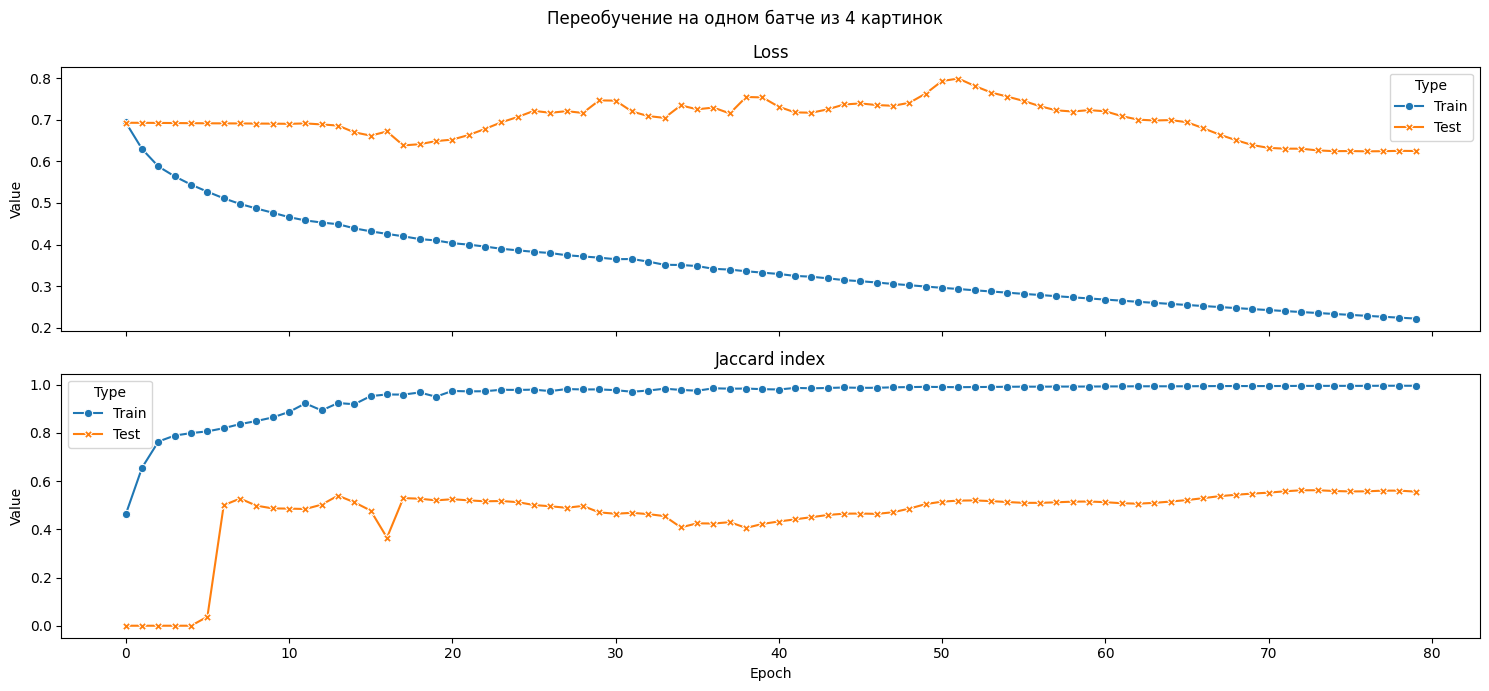

In [33]:
display_stats(train_stats, test_stats, "Переобучение на одном батче из 4 картинок")

На графиках видно, что с увеличением числа эпох обучения модели значение функции потерь уменьшалось, а значение индекса Жаккара стремится к 1.
На тестовых данных значения метрик плохие.

# **Полное обучение**

In [ ]:
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats, test_stats = train(
    30, model, train_loader, test_loader, optimizer
)

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

1  Train loss:  0.5421561768319871 , train jaccard:  0.625499384270774 , test loss:  0.7197239828109742 , test jaccard:  0.6136437916755676


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

2  Train loss:  0.4288857277234395 , train jaccard:  0.7031043468581306 , test loss:  0.5021344661712647 , test jaccard:  0.6496125411987305


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

3  Train loss:  0.3854339343971676 , train jaccard:  0.7347798567348056 , test loss:  0.40032126545906066 , test jaccard:  0.7222744226455688


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

4  Train loss:  0.33946939786275226 , train jaccard:  0.7657596256997851 , test loss:  0.34052076637744905 , test jaccard:  0.7638945436477661


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

5  Train loss:  0.30362936668925816 , train jaccard:  0.790978078312344 , test loss:  0.2843040895462036 , test jaccard:  0.7974628734588624


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

6  Train loss:  0.27637083285384706 , train jaccard:  0.8103986517588297 , test loss:  0.27367610156536104 , test jaccard:  0.8010045838356018


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

7  Train loss:  0.2566752454969618 , train jaccard:  0.8247866837183634 , test loss:  0.24781214892864228 , test jaccard:  0.8286581945419311


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

8  Train loss:  0.2271041312151485 , train jaccard:  0.8456580098470052 , test loss:  0.2278391921520233 , test jaccard:  0.845742347240448


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

9  Train loss:  0.20779363579220242 , train jaccard:  0.8588244231541952 , test loss:  0.220398730635643 , test jaccard:  0.853418345451355


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

10  Train loss:  0.1980505880051189 , train jaccard:  0.8660429334640503 , test loss:  0.22829151004552842 , test jaccard:  0.8504789924621582


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

11  Train loss:  0.18303962906201682 , train jaccard:  0.876849029329088 , test loss:  0.22261009752750396 , test jaccard:  0.8565301632881165


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

12  Train loss:  0.17073629415697522 , train jaccard:  0.8853746334711711 , test loss:  0.21282199800014495 , test jaccard:  0.8643731689453125


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

13  Train loss:  0.16204035815265444 , train jaccard:  0.8910724197493659 , test loss:  0.20379393935203552 , test jaccard:  0.868755943775177


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

14  Train loss:  0.1551450560821427 , train jaccard:  0.8960179903772142 , test loss:  0.20196506828069688 , test jaccard:  0.8725735330581665


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

15  Train loss:  0.14671295589870878 , train jaccard:  0.9014867769347297 , test loss:  0.2184905529022217 , test jaccard:  0.8672069644927979


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

16  Train loss:  0.14189525057872138 , train jaccard:  0.9054358601570129 , test loss:  0.20309292763471604 , test jaccard:  0.8739366126060486


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

17  Train loss:  0.13357175293895934 , train jaccard:  0.9106560640864902 , test loss:  0.2058966875076294 , test jaccard:  0.8763857412338257


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

18  Train loss:  0.12847691184944576 , train jaccard:  0.9145528197288513 , test loss:  0.21249592006206514 , test jaccard:  0.872190043926239


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

19  Train loss:  0.1212706576122178 , train jaccard:  0.9191767054133945 , test loss:  0.20943428963422775 , test jaccard:  0.8783950161933899


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

20  Train loss:  0.11637113592690891 , train jaccard:  0.9225626842180887 , test loss:  0.20964208364486694 , test jaccard:  0.87973947763443


  0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
display_stats(train_stats, test_stats, "Полное обучение")

In [ ]:
model.eval()
worst_idx = worst_cases(model, 3, [])

# **Улучшение модели без изменения архитектуры**

### **Аугментация тренировочных данных**

Попробуем улучшить модель посредством добавления отраженных по вертикали  изображений в тренировочный набор данных.

In [ ]:
batch_size = 8

augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=1)
    ]
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

X_org, y_orig = train_dataset[66]
X_mirror, y_mirror = train_dataset_augmented[66]
display_image(X_orig, y_orig)
display_image(X_mirror, y_mirror)

train_dataset_extended = ConcatDataset(
    [train_dataset, copy.copy(train_dataset)]
)

train_loader_extended = DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

In [ ]:
model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats_with_augmentations, test_stats_with_augmentations = train(
    30, model, train_loader, test_loader, optimizer
)

In [ ]:
display_stats(train_stats_with_augmentations, test_stats_with_augmentations, "Обучение модели с аугментацией данных")

### **Test-time аугментации**

Попробуем также улучшить качество предсказания посредством проведения test-time аугментации через horizontal flip.

In [ ]:
class UNetHFlipWrapper(nn.Module):
    def __init__(self):
        super(UNetHFlipWrapper, self).__init__()
        self.unet = UNET(3, 16, 1)

    def forward(self, x):
        x = torch.cat([x, functional.hflip(x)])
        x = self.unet(x)
        x, x_alt = torch.chunk(x, 2)
        x_alt = functional.hflip(x_alt)
        stacked = torch.stack([x, x_alt])
        means = torch.mean(stacked, dim=0)

        return means

In [ ]:
hflip_wrapped_model = UNetHFlipWrapper().cuda()
hflip_wrapped_model.unet.load_state_dict(model.state_dict())

In [ ]:
print("Flip-wrapped test results (loss, jaccard):", test(hflip_wrapped_model, test_loader))

# **Улучшение модели с изменением архитектуры**

Попробуем увеличить количество сверток на каждом уровне с 2 до 4.

In [ ]:
class EncoderModified(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(EncoderModified, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=4, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class UNETModified(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNETModified, self).__init__()
        self.encoder = EncoderModified(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [ ]:
model = UNETModified(3, 16, 1).cuda()
optimizer = torch.optim.Adam(model.parameters())
train_stats_modified, test_stats_modified = train(
    30, model, train_loader, test_loader, optimizer
)

In [ ]:
display_stats(train_stats_modified, test_stats_modified, "Обучение модели с 4-мя свертками на каждом уровне")